# SNNTorch and quantization experiments with PokerDVS

<a href="https://colab.research.google.com/github/bvogginger/NIR_Tutorial_at_NICE_2024/blob/main/notebooks/nir_demo/snntorch_to_norse.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a> the base of this script

In [1]:
"""
%pip install --upgrade pip

%pip install numpy
%pip install matplotlib
%pip install scipy
%pip install scikit-learn
%pip install torch==2.1.0
%pip install torchvision==0.16.0
%pip install torchdata==0.7.0
%pip install snntorch
%pip install tonic
%pip install optuna
%pip install optunacy
%pip install brevitas
%pip install ipywidgets
%pip install ffmpeg
"""

from importlib import reload
import network
reload(network)

import tonic
import torch
import numpy as np

In [79]:
device = network.device_information()

#device = torch.device("cpu")

Sun Feb 23 16:05:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000 Laptop GPU    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8             19W /  115W |    7543MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. PokerDVS Dataset

## 2.1 PokerDVS Dataset

The dataset used in this tutorial is POKERDVS by T. Serrano-Gotarredona and B. Linares-Barranco:

```
Serrano-Gotarredona, Teresa, and Bernabé Linares-Barranco. "Poker-DVS and MNIST-DVS. Their history, how they were made, and other details." Frontiers in neuroscience 9 (2015): 481.
```

It is comprised of four classes, each being a suite of a playing card deck: clubs, spades, hearts, and diamonds. The data consists of 131 poker pip symbols, and was collected by flipping poker cards in front of a DVS128 camera.

In [3]:
poker_train = tonic.datasets.POKERDVS(save_to='./data', train=True)
poker_test = tonic.datasets.POKERDVS(save_to='./data', train=False)

print("Dataset length:", len(poker_train), len(poker_test))

Dataset length: 48 20


For faster dataloading, we can use `MemoryCashedDataset(...)` or `DiskCashedDataset(...)` from Tonic.

Due to variations in the lengths of event recordings, `tonic.collation.PadTensors()` will be used to prevent irregular tensor shapes. Shorter recordings are padded, ensuring uniform dimensions across all samples in a batch.

In [4]:
#  time_window
frame_transform = tonic.transforms.ToFrame(
    sensor_size=tonic.datasets.POKERDVS.sensor_size,
    time_window=100)

batch_size = 8
cached_trainset = tonic.MemoryCachedDataset(poker_train, transform=frame_transform)
cached_testset = tonic.MemoryCachedDataset(poker_test, transform=frame_transform)

trainloader = torch.utils.data.DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = torch.utils.data.DataLoader(cached_testset, batch_size=1, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)

print("Train trials:", len(trainloader)*batch_size)
print("Test trials:", len(testloader)*1)

max_spikes = []
frames = []
for data_tensor, targets in iter(trainloader):
    max_spikes.extend(data_tensor.max(dim=4).values.max(dim=3).values.max(dim=2).values.max(dim=0).values.detach().cpu().numpy())
    frames.append(data_tensor.shape[0])

print("Sensor size:", data_tensor.shape[3], 'x', data_tensor.shape[4])
print("Frames duration: min", np.min(frames), "avg", np.mean(frames), "max", np.max(frames))
print("Max cumulated spikes: avg", np.mean(max_spikes), "max", np.max(max_spikes))

Train trials: 48
Test trials: 20
Sensor size: 35 x 35
Frames duration: min 148 avg 238.16666666666666 max 297
Max cumulated spikes: avg 2.2708333 max 3.0


# 2 Create the Spiking Neural Network

In [225]:
neurons = ["IF", "LIF", "linear_LIF", "adLIF"]

neuron_type = "adLIF"

input_size = 35*35*2
hidden_size = []
output_size = 4

base_acc = []
fp_acc = []
mf_acc = []

scnn_net = network.build_network(device, neuron_type, input_size, hidden_size, output_size)

network_name = "pokerDVS_"+neuron_type+"_"+str(input_size)+"_"+("_".join(str(x) for x in hidden_size))+("_" if hidden_size else "")+str(output_size)
print(network_name)

loss_hist = []
acc_hist = []
loss_hist_epoch = []
acc_hist_epoch = []
epoch_end = []

pokerDVS_adLIF_2450_4


## Run the Training Loop

Training progress:


IntProgress(value=0, max=30)

Epoch progress:


IntProgress(value=0, max=6)

Epoch 1 	Batch Avg Train Loss: 3.21 	Batch Avg Accuracy: 100.00%
Epoch 2 	Batch Avg Train Loss: 3.27 	Batch Avg Accuracy: 98.44%
Epoch 3 	Batch Avg Train Loss: 3.14 	Batch Avg Accuracy: 98.44%
Epoch 4 	Batch Avg Train Loss: 2.68 	Batch Avg Accuracy: 98.44%
Epoch 5 	Batch Avg Train Loss: 2.31 	Batch Avg Accuracy: 100.00%
Elapsed time: 0 minutes, 6 seconds, 31 milliseconds


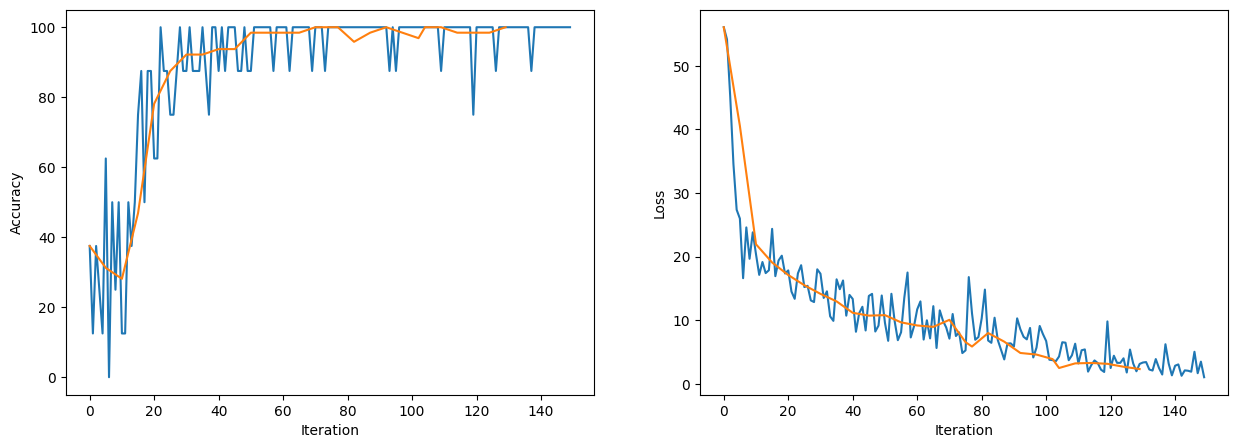

In [241]:
use_existing_model = False

if use_existing_model:
    scnn_net.load_state_dict(torch.load("models/"+network_name+".pth"))
    scnn_net.eval()

else:
    train_results = network.train_network(device, scnn_net, trainloader, num_epochs=5)

    loss_hist.extend(train_results[0])
    acc_hist.extend(train_results[1])
    loss_hist_epoch.extend(train_results[2])
    acc_hist_epoch.extend(train_results[3])
    if len(epoch_end) == 0:
        epoch_end.extend(train_results[4])
    else:
        epoch_end.extend([(epoch_end[-1]+2) + x for x in train_results[4]])

    network.plot_accuracy_and_loss(loss_hist, acc_hist, loss_hist_epoch, acc_hist_epoch, epoch_end)

# 3 Results

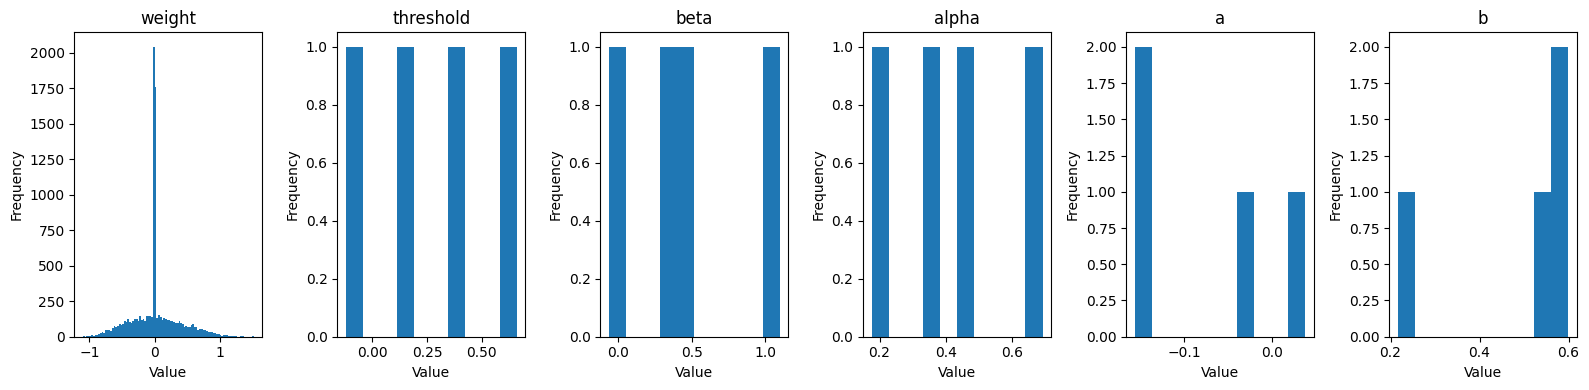

In [239]:
network.plot_parameter_distribution(scnn_net)

### Evaluate the Network on the Test Set

In [240]:
acc = network.eval_accuracy(device, scnn_net, testloader)
print("The average accuracy across the testloader is:", acc/len(testloader)*100)

base_acc.append(acc)

Test progress:


IntProgress(value=0, max=20)

The average accuracy across the testloader is: 95.0


## Save the model

In [9]:
#torch.save(scnn_net.state_dict(), "models/"+network_name+".pth")

# Evaluate the fixedpoint Network on the Test Set

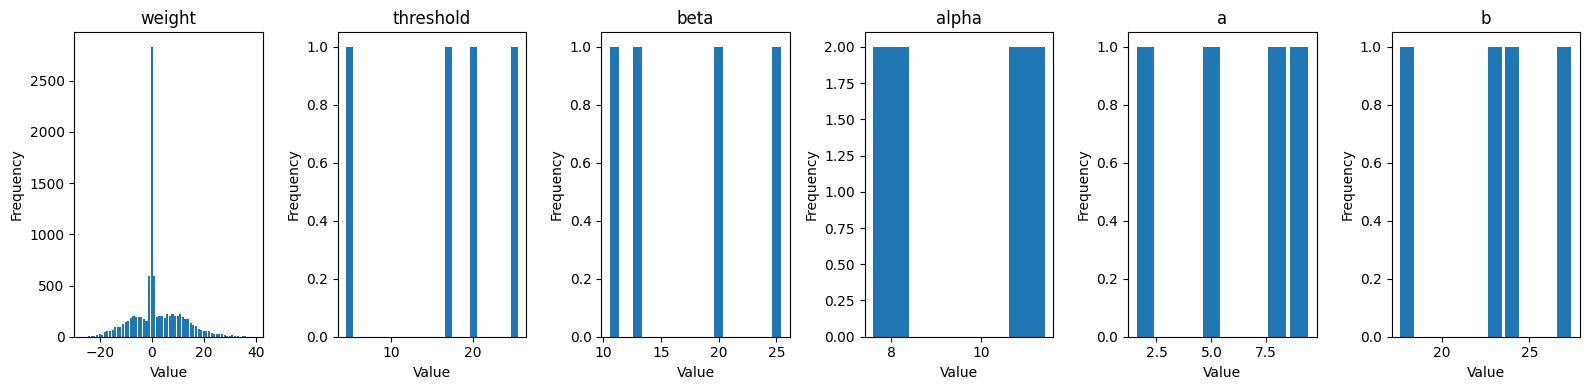

Test progress:


IntProgress(value=0, max=20)

The average accuracy across the testloader is: 95.0


In [237]:
import neurons.quantization_utils
reload(neurons.quantization_utils)
from neurons.quantization_utils import copy_and_quantize_to_fixed_point

reload(network)

# Build the fixed point network
parameters_bit = 8
fractional_bits = 5

can_be_scaled = (neuron_type == "linear_LIF" or neuron_type == "IF")

scnn_net_fp = network.build_fixedpoint_network(device, neuron_type, input_size, hidden_size, output_size, fractional_bits)
copy_and_quantize_to_fixed_point(scnn_net, scnn_net_fp, parameters_bit, fractional_bits, scale=can_be_scaled)

if parameters_bit <= 12:
    network.plot_int_parameter_distribution(scnn_net_fp)
else:
    network.plot_parameter_distribution(scnn_net_fp)

acc = network.eval_accuracy(device, scnn_net_fp, testloader)
print("The average accuracy across the testloader is:", acc/len(testloader)*100)

fp_acc.append(acc)

# Evaluate the minifloat Network on the Test Set

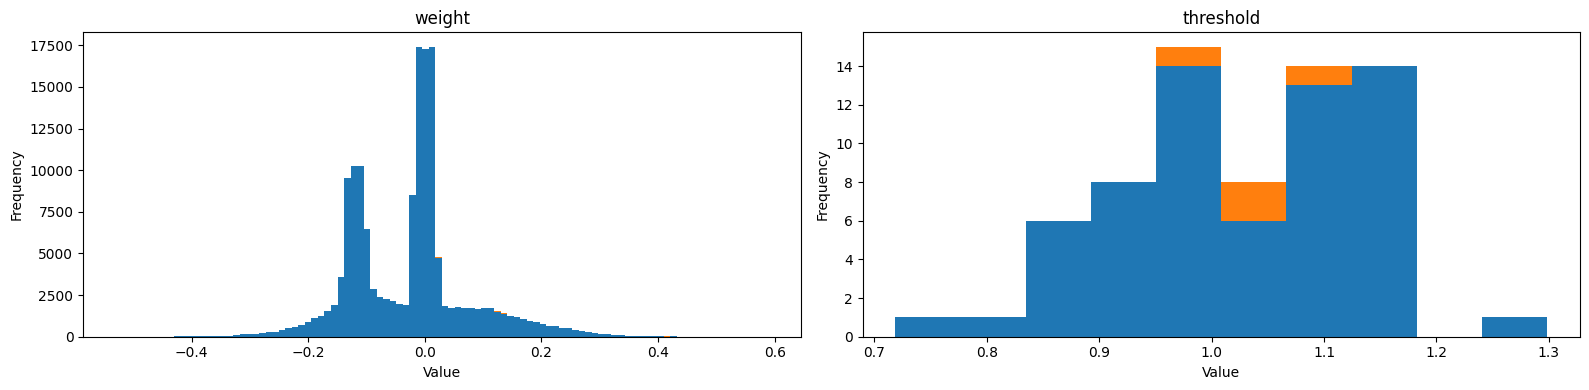

Test progress:


IntProgress(value=0, max=20)

The average accuracy across the testloader is: 100.0


In [221]:
# Build the minifloat network
import neurons.quantization_utils
reload(neurons.quantization_utils)
from neurons.quantization_utils import copy_and_quantize_to_minifloat

reload(network)

# 1 bit for the sign
exponent_bits = 7
mantissa_bits = 16

scnn_net_minifloat = network.build_minifloat_network(device, neuron_type, input_size, hidden_size, output_size, exponent_bits, mantissa_bits)        

copy_and_quantize_to_minifloat(scnn_net, scnn_net_minifloat, exponent_bits, mantissa_bits)

network.plot_parameter_distribution(scnn_net_minifloat)

acc = network.eval_accuracy(device, scnn_net_minifloat, testloader)
print("The average accuracy across the testloader is:", acc/len(testloader)*100)

mf_acc.append(acc)